In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print(tf. __version__) 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  1


2021-11-29 12:48:09.449474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 12:48:09.469220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 12:48:09.470336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Processing Data

In [2]:
def get_features_and_target(csv_file):
    df = pd.read_csv(f'../spark_output/colorado/{csv_file}')
    df.drop(['year_month_day'], axis=1, inplace=True)

    features = df.iloc[:, 1:-1].values
    target = df.iloc[:, 0].values.reshape(-1,1)

    assert features.shape[0] == target.shape[0]
    assert target.shape[1] == 1

    return features, target


In [19]:
def split_train_test_val(x_values, y_values):
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.20, random_state=42)

    # 0.25 x 0.8 = 0.2
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

    assert x_train.shape[0] == y_train.shape[0]
    assert x_test.shape[0] == y_test.shape[0]
    assert x_validate.shape[0] == y_validate.shape[0]

    return [x_train, x_test, x_validate], [y_train, y_test, y_validate]

## Model Building

In [20]:
def model_build(layers, input_shape, dropout):    

    model_layers = [tf.keras.layers.Dense(layers[0], activation='relu', input_shape=input_shape)]
    
    for curr_layer in layers[1:]:
        model_layers.append(tf.keras.layers.Dense(curr_layer, activation='relu'))
        if dropout:
            model_layers.append(tf.keras.layers.Dropout(0.2))


    model_layers.append(tf.keras.layers.Dense(1))

    return tf.keras.models.Sequential(model_layers)

In [71]:
def run_deep_learning(county, hidden_layers, learning_rate=0.01, epochs=1000, batch_size=256, dropout=False):
 
    features, target = get_features_and_target(county)

    X, Y = split_train_test_val(features, target)
    x_train, x_test, x_validate = X
    y_train, y_test, y_validate = Y
    
    input_shape = tuple([x_train.shape[1]], )
    loss_function = 'mae'
    metric_type = ['mae']


    model = model_build(hidden_layers, input_shape=input_shape ,dropout=dropout)
    model.summary()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=loss_function, metrics=metric_type)
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_validate, y_validate))

    model.evaluate(x_test, y_test)
    
    return history, model

In [72]:
gunnison = "G0800510.csv"
fremont = "G0800430.csv"

In [78]:
gunnison_history, gunnison_model = run_deep_learning(gunnison, [100], learning_rate=0.01, epochs=1000, batch_size=512)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 100)               300       
                                                                 
 dense_65 (Dense)            (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 577ms/step - loss: 97.9517 - mae: 97.9517 - val_loss: 44.3242 - val_mae: 44.3242
Epoch 2/1000
1/1 [==============================] - 0s 53ms/step - loss: 46.7369 - mae: 46.7369 - val_loss: 45.0166 - val_mae: 45.0166
Epoch 3/1000
1/1 [==============================] - 0s 33ms/step - loss: 42.3666 - mae: 42.3666 - val_loss: 54.4995 - val_mae: 54.4995
Epoch 4/1000
1/1 [===========================

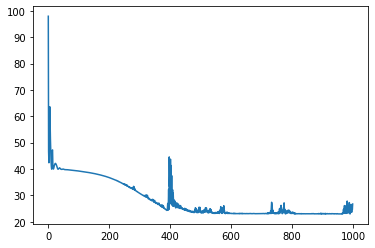

In [79]:
plt.plot(gunnison_history.history['loss'])

## Display Results

In [24]:
def display_loss(model_history, SKIP=10):
    '''
    Draws a graph of the loss, which is the distance between
    the predicted and actual values during training and validation.
    
    Parameters: 
        model_history (tensorflow.history object): A models history after training.
        SKIP (int): Amount of epochs to skip before graphing. 10 by default.
    '''

    for curr_history in model_history:
        train_loss = curr_history['loss']
        val_loss = curr_history['val_loss']

        epochs = range(1, len(train_loss) + 1)

        plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
        plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
        plt.title(f"Activation Function: {curr_history['a_function']} \n Arch: {curr_history['arch']}\n Training and validation loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [ ]:
def display_accuracy(model_history, SKIP=10):
    
    '''
    Draws a graph of the accuracy over the duration of training.
    
    Parameters: 
        model_history (tensorflow.history object): A models history after training.
        SKIP (int): Amount of epochs to skip before graphing. 10 by default.
    '''
    
    for curr_history in model_history:
        plt.clf()

        # Draw a graph of mean absolute error, which is another way of
        # measuring the amount of error in the prediction.
        train_mae = curr_history['accuracy']
        val_mae = curr_history['val_accuracy']
        
        epochs = range(1, len(train_mae) + 1)

        plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training Accuracy')
        plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation Accuracy')
        plt.title(f"Activation Function: {curr_history['a_function']} \n Arch: {curr_history['arch']}\n Training and validation accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('ACC')
        plt.legend()
        plt.show()